# Portfolio Risk Engine — Offline Demo (CSV-only)

This notebook runs **entirely offline** on any laptop. It uses the synthetic datasets shipped in the repo:

- `data/prices_small.csv` (≈6 months, 5 tickers)
- `data/prices_medium.csv` (≈2 years, 8 tickers)

What you'll see:
1. Portable bootstrap (no hard-coded usernames) to import the project.
2. Data diagnostics (null checks, per-ticker counts).
3. Backtest with equal weights, KPIs saved to `data/kpis.json`.
4. Matplotlib plots (no seaborn): cumulative portfolio curve.
5. Simple robustness sweep over `window`/`step`.
6. Exception handling demo for CSV schema.


In [8]:
!pip3 install pandas matplotlib datetime


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [9]:
# Imports (CSV-only)
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from core.data import load_prices_csv, save_kpis, SchemaError
from core.backtest import run_backtest
from core.model import compute_returns

pd.set_option("display.max_rows", 8)
pd.set_option("display.width", 120)


## 1) Load synthetic CSV
Choose one of the bundled synthetic datasets. Both follow the long format
`date,ticker,adj_close` and are sorted by `ticker,date`.

In [10]:
CSV_PATH = "../data/prices_small.csv"
prices = load_prices_csv(CSV_PATH)
prices.head(6)

,date,ticker,adj_close
0,2025-01-02,AAA,99.539197
1,2025-01-03,AAA,97.700184
2,2025-01-06,AAA,98.311520
3,2025-01-07,AAA,98.330364
4,2025-01-08,AAA,96.750339
5,2025-01-09,AAA,95.223668


### Diagnostics: shape, nulls, per-ticker counts

In [11]:
print("Rows:", len(prices), "Unique tickers:", prices['ticker'].nunique())
print("Date range:", prices["date"].min().date(), "→", prices["date"].max().date())
print("Nulls by column:\n", prices.isna().sum())
print("Per-ticker counts:\n", prices.groupby("ticker").size())


Rows: 640 Unique tickers: 5
Date range: 2025-01-02 → 2025-06-30
Nulls by column:
 date         0
ticker       0
adj_close    0
dtype: int64
Per-ticker counts:
 ticker
AAA    128
BBB    128
CCC    128
DDD    128
EEE    128
dtype: int64


## 2) Backtest with equal weights

In [12]:
tickers = list(prices["ticker"].unique())
init_w = {t: 1.0/len(tickers) for t in tickers}
tgt_w  = init_w.copy()

kpis = run_backtest(prices, init_w, tgt_w, window=60, step=20)
kpis

{'total_return': -0.042128583443548306,
 'ann_vol': 0.14918977432936292,
 'hist_VaR': 0.01490914723585465,
 'hist_CVaR': 0.018160891865048684,
 'norm_VaR': 0.015753482353834506,
 'sharpe': -0.4983402911960621,
 'sortino': -0.9056975343003546,
 'max_drawdown': -0.14739146536427583,
 'calmar': -0.5553932460340606,
 'turnover_L1': 0.0,
 'cost_estimate': 0.0,
 'n_days': 127}

In [13]:
# Save KPIs to JSON (repo-relative)
save_kpis("data/kpis.json", kpis)
print("KPIs saved to data/kpis.json at", datetime.now())

KPIs saved to data/kpis.json at 2025-12-15 17:35:12.700757


## 3) Plot cumulative portfolio curve (matplotlib)

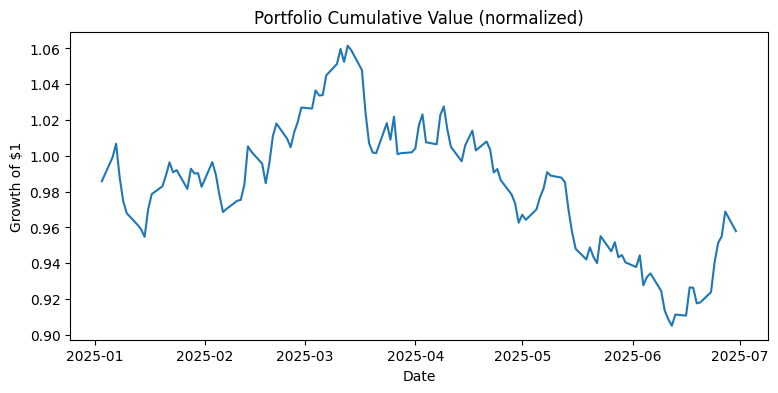

In [14]:
wide = prices.pivot(index="date", columns="ticker", values="adj_close").dropna(how="any")
rets = compute_returns(wide)
w_vec = [init_w.get(t, 0.0) for t in wide.columns]
curve = (1 + (rets * w_vec).sum(axis=1)).cumprod()

plt.figure(figsize=(9,4))
plt.plot(curve.index, curve.values)
plt.title("Portfolio Cumulative Value (normalized)")
plt.xlabel("Date"); plt.ylabel("Growth of $1")
plt.show()

## 4) Robustness sweep (window/step)
Try a small grid of `(window, step)` to see how KPIs move. This demonstrates loops and dictionary/list comprehensions in practice.

In [15]:
grid = [(40,10), (60,20), (80,20), (100,25)]
results = []
for win, st in grid:
    res = run_backtest(prices, init_w, tgt_w, window=win, step=st)
    res = {**res, "window": win, "step": st}
    results.append(res)
pd.DataFrame(results)


,total_return,ann_vol,hist_VaR,hist_CVaR,norm_VaR,sharpe,sortino,max_drawdown,calmar,turnover_L1,cost_estimate,n_days,window,step
0,-0.042129,0.14919,0.014909,0.018161,0.015753,-0.49834,-0.905698,-0.147391,-0.555393,0.0,0.0,127,40,10
1,-0.042129,0.14919,0.014909,0.018161,0.015753,-0.49834,-0.905698,-0.147391,-0.555393,0.0,0.0,127,60,20
2,-0.042129,0.14919,0.014909,0.018161,0.015753,-0.49834,-0.905698,-0.147391,-0.555393,0.0,0.0,127,80,20
3,-0.042129,0.14919,0.014909,0.018161,0.015753,-0.49834,-0.905698,-0.147391,-0.555393,0.0,0.0,127,100,25


## 5) Exception handling demo
We intentionally try to load a CSV with the wrong schema and show a `SchemaError`.

In [16]:
from tempfile import TemporaryDirectory
bad_csv_content = "d,t,px\n1,2,3\n"
try:
    import pathlib as _pl
    with TemporaryDirectory() as td:
        p = _pl.Path(td) / "bad.csv"
        p.write_text(bad_csv_content)
        _ = load_prices_csv(p)  # should raise
except SchemaError as e:
    print("Caught SchemaError as expected:", e)
except Exception as e:
    print("Unexpected exception:", type(e).__name__, e)


Unexpected exception: ValueError Missing column provided to 'parse_dates': 'date'
